# How Can We Train Intelligent Agents?

Let's anchor ourselves in the performance scale from Prof. Nguyen's video:


![](range.png)

# Evolutionary Algorithm
- Gradient Free

### Greatest Sampling Requirements
- Approximate Exhaustive Search



![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1803.png)

![](range.png)

# RL - policy gradients (PG)
- algorithm focused *on-policy* parameters

### Great Sampling Requirements
- sampling inefficient: "needs to explore the game for a very long time before it can make significant progress"
- Ideas for improved speed 
    - **Initialize to a decent policy**
        - "if you already have a reasonably good policy (e.g., hardcoded) ... train the neural network to imitate it before using policy gradients"
    - **Make rewards less sparse**
        - CartPole-v1: "add negative rewards proportional to the pole’s angle [to] make the rewards much less sparse and speed up training"

## OpenAI Gym

In [462]:
# `conda install -c conda-forge gym`
import gym


- Hands-On ML textbook has great chapters walking through different topics (such as RL)
    - (if you haven't already seem some of it)
    - I'm adapting much of that material here

In [472]:
# from Hands-On ML book...

# if you're rendering with `env.render()` like below
# close before starting new env; otherwise, not needed
env.close()
env = gym.make("CartPole-v1")

obs = env.reset()
obs


array([ 0.0402237 ,  0.0360499 ,  0.02634094, -0.0173531 ])

*Environment `obs` contains the following:*
1. horizontal position (0.0 = center)
2. velocity (positive means right)
3. angle of the pole (0.0 = vertical)
4. angular velocity (positive means right)

*Actions we can take:*

0. Left
1. Right

In [468]:
# left/right: 0/1
env.action_space


Discrete(2)

- Sweet video game quality graphics available with `env.render()`
    - **Make sure you CLOSE THE WINDOW WITH `env.close()`**
        - *or the window won't close until the kernel restarts/dies*

`env.close()` only closes the window, not the "environment session"

In [473]:
env.render()
#env.close()

True

### Let's play! 
- just run this a few times!

In [527]:
action = 1 # accelerate right
obs, reward, done, info = env.step(action)
obs
env.render()


True

- Game ends a little early, I would say, sadly...
    - Or maybe it closes once you're past the point of "no return" and can't save it?

In [528]:
(reward, done, info)

(0.0, True, {})

- Close window with `env.close()` when you're done 
- BEFORE making new `env = gym.make("CartPole-v1")`
    - or you'll lose your pointer to the window
    - and won't be able to close it without a kernel restart/shutdown
  
  
`env.close()` only closes the window, not the "environment session"
    

In [529]:
env.close()

### First Policy!
- go in the direction to poll is tipping (to save it!)

In [530]:
def basic_policy(obs):
    
    '''go in the direction to poll is tipping (to save it!)'''
    
    angle = obs[2]
    
    return 0 if angle < 0 else 1


- now let's run our agent a bunch of times to see how it does!

In [533]:
from time import sleep
import numpy as np

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        # added commented code 
        # https://github.com/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb
        sleep(.01)
        env.render()
        
        # let's let the game play all the way out
        done = obs[2]<-np.pi/2 or obs[2]>np.pi/2        
        if done:
            sleep(.1)
            break
    totals.append(episode_rewards)

KeyboardInterrupt: 

In [532]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(65.96, 9.376054607349513, 44.0, 97.0)

### Now let's build a model the predicts L/R according to the `obs` environment
- and beat our simple agent above
- **But notice: our parameters are set to *make decisions***
    - this is why this is an **on-policy** algorithm
    - it needs to learn how to react to all environmental conditions
    - ***[as opposed to just learning if something is good or bad]***

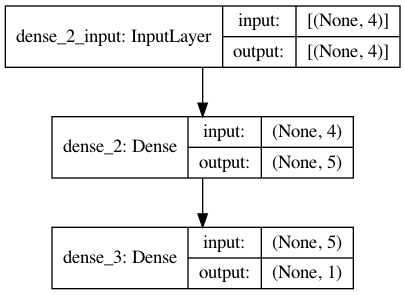

In [534]:
import tensorflow as tf
from tensorflow import keras

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

# https://keras.io/api/utils/model_plotting_utils/
tf.keras.utils.plot_model(model, show_shapes=True)

#### REINFORCE ALGORITHM
- remember every move we made
- and the gradient 
    - so we can make those moves more or less likely

In [ ]:
# reworked from book

loss_fn = keras.losses.binary_crossentropy

def gradient_to_REINFORCE_move(obs, model, loss_fn):  
    
    '''We move in some direction:
    
       What's the gradient of the parameters that make
       it even MORE likely to move in that direction?
       
       Later, when we decide if we like the move or not,
       we can follow the gradient to REINFORCE the move 
       or, or the negative of the gradient to dscount it
    '''
    
    with tf.GradientTape() as tape:
        
        prob_right = model(obs[np.newaxis])
        
        # what we did: just a chance according to the currently predicted probability
        bool_right = tf.random.uniform([1, 1]) < prob_right
        action = tf.cast(bool_right, tf.float32)
        
        # we "want" the predicted prob to even better reflect what we did
        loss = tf.reduce_mean(loss_fn(action, prob_right))

    # so how do the model variables change to make the predicted probs
    # better match what we did?  Record these adjustments
    grads = tape.gradient(loss, model.trainable_variables)
                                     
    return action, grads
                        
                                       
def play_one_step_get_AND_gradient_to_REINFORCE_move(env, obs, model, loss_fn):
                                           
    '''get `obs`; take an action in `env`; record gradients to REINFORCE move'''
    
    action,grads = gradient_to_REINFORCE_move(obs, model, loss_fn)                                   
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
                                       
    return obs, reward, done, grads

### Play sessions management

#### `play_an_episode`
1. re-apply `play_one_step_get_AND_gradient_to_REINFORCE_move`
    - updating `env` state; recording REINFORCE gradients; and how long we've stayed "alive"
    - until we hit *done*
    - 

#### `play_multiple_episodes`
2. repeat a series of the above *full game* runs
    - the `reward` for each game is how long we stayed "alive" in that game
    

#### Sneak Peak

Each set of gradients attached to a game with a `reward`
- following the gradients "down" to reduce "loss" makes the predicted probabilities closer to the actions we took
- so we should do ths for the "good" games
- and maybe the opposite for the "bad" games

In [535]:
# reworked from book

def play_an_episode(env, n_max_steps, model, loss_fn):

    '''Play moves until game is finished,
       and keep the gradient that would 
       REINFORCE each move, and keep the
       rewards measured during the game
    '''
    
    current_rewards = []
    current_grads = []
    obs = env.reset()
    for step in range(n_max_steps):
        obs, reward, done, grads =\
        play_one_step_get_AND_gradient_to_REINFORCE_move(env, obs, model, loss_fn)
        current_rewards.append(reward)
        current_grads.append(grads)
        if done:
            break
            
    return current_rewards,current_grads

        
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):

    '''Play several games, and collect for each game,
       the gradients that would REINFORCE each move
       and the measured rewards for each move made
    '''

    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        episode_rewards,episode_grads = play_an_episode(env, n_max_steps, model, loss_fn)
        all_rewards.append(episode_rewards)
        all_grads.append(episode_grads)
        
    return all_rewards, all_grads

### More Details on `Rewards`
- 1 point for each time step
- plus discounted 
    - if we're still alive later, then maybe the earlier moves were even better than we thought!

In [536]:
# *slightly* reworked from book

def discount_rewards(rewards, discount_factor):
    
    '''For each completed game, address the credit assignment 
       problem by applying the discounted rewards strategy:
    '''
    
    discounted_rewards = np.array(rewards)
    # work from the end: multiply by the discount factor and add to the previous step
    # in this way we accumulate the power decayed scores through the earlier moves
    for step in range(len(rewards)-2, -1, -1):
        discounted_rewards[step] += discounted_rewards[step+1] * discount_factor
        
    return discounted_rewards

discount_rewards([10, 0, -50], discount_factor=.8)


array([-22, -40, -50])

In [538]:
-50*.8*.8

-32.0

#### Good or Bad game?

- Just normalize the scores: subtract mean an divide by standard deviation
- Above average is REINFORCED (proportionally to how good a game is relatively)
    - and we do the opposite for below average (proportionally to how bad a game is relatively)

In [539]:
# reworked from book

def normalize_rewards(all_rewards):
    
    '''Subtract and then divide each reward by 
       the global mean and standard deviation 
       of all rewards across all games played
    '''

    flat_rewards = np.concatenate(all_rewards)
    all_rewards_mean = flat_rewards.mean()
    all_rewards_std = flat_rewards.std()
    return [(single_episode_rewards-all_rewards_mean)/all_rewards_std
            for single_episode_rewards in all_rewards]

discounted_rewards = discount_rewards([10, 0, -50], discount_factor=0.8)
normalize_rewards([discounted_rewards])


[array([ 1.32350128, -0.23017414, -1.09332714])]

- And here we just put together the `discount_rewards` and `normalize_rewards`
    - so we can just call it all at once we've collected all the games

In [540]:
# reworked from book

def discount_and_normalize_rewards(all_rewards, discount_factor):
    
    '''Use the functions above to tranform
       rewards to discounted rewards and
       normalize the discounted rewards
    '''
    
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    
    return normalize_rewards(all_discounted_rewards)
    
    
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8)


[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

#### REINFORCE algorithm at work
- One "epoch" (of which we'll do 150)
    1. Play 10 games (i.e., episodes)
    2. discount/normalize each actions score; and, relatively update parameters with the associated gradients 
        - gradients REINFORCE the actions
            - so we follow the gradients for actions with "good"
                - and go in the opposite direction of the gradient for actions with "bad" scores
        - This is accomplished by using a *weighted average* of each parameters gradients based on the associated *relative* discounted/normalized action scores


In [541]:
# reworked from book

optimizer = keras.optimizers.Adam(lr=0.01)

n_gradient_updates = 150
n_episodes_per_update = 10
n_max_actions_per_episodes = 200
discount_factor = 0.95

for index in range(n_gradient_updates):
    
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, 
                                                    n_max_actions_per_episodes, 
                                                    model, loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    
    # 1. Each move in each game now has a normalized discounted score
    # 2. We have the gradient that REINFORCES each move
    # 3. We weight each gradient by the move's normalized discounted score
    #    - positive scores REINFORCE the move: 
    #      i.e., the direction of the gradient REINFORCES the move
    #    - negative scores SUPRESS the move:
    #      i.e., the negative direction of the gradient SUPRESSES the move
    # 4. We average the gradients for each `model.trainable_variables`
    
    # We do it this way because of how we ended
    # up storing lists of gradients and scores
    trainable_variables_mean_grad = []
    for trainable_variables_index in range(len(model.trainable_variables)):
        grad_mean = tf.reduce_mean([
            
        final_reward*all_grads[episode_index][action_index][trainable_variables_index]
            
        for episode_index,final_rewards in enumerate(all_final_rewards)
            for action_index,final_reward in enumerate(final_rewards)
            
                                    ], axis=0)
        
        trainable_variables_mean_grad.append(grad_mean)

    optimizer.apply_gradients(zip(trainable_variables_mean_grad, 
                                  model.trainable_variables))

- And we've seen this next code below already up above before - just plays/shows the games:

In [544]:
totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = int(np.random.random() < model(obs[np.newaxis]))
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        
        #sleep(.01)
        #env.render()
        done = obs[2]<-np.pi/2 or obs[2]>np.pi/2 
        if done:
            #sleep(.1)
            break
    totals.append(episode_rewards)
    
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)    

(197.252, 11.444321561368326, 95.0, 200.0)

In [543]:
env.close()

In [ ]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)    

# Q-Learning Algorithm V1

- Theoretical/Pedagogical


## Markov decision processes (MDPs)
### Hands-On ML Textbook Example:

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1808.png)



#### Bellman Optimality Equation



$\underline{\textbf{FOR EACH } s}$
$$
\begin{align*}
\displaystyle 
\underbrace{Value^{optimal}(State_s)}_{V^*(s)} = & {} \sum_{s'} 
\underbrace{Pr(State_s\rightarrow State_{s'}| Action^{optimal})}_{ p_{a}(s\rightarrow s')} \,\times \left[ \underbrace{Reward(State_s\rightarrow State_{s'}| Action^{optimal})}_{$_{a}(s\rightarrow s')}
+  \underbrace{\overset{\huge \text{FUTURE}}{\gamma Value^{optimal}(State_{s'})}}_{\gamma V^*(s')} \right]
\\
V^*(s) = & {} \underset{a}{\max} \sum_{s'} p_{a}(s\rightarrow s') \times \left[ $_{a}(s\rightarrow s') \, + \gamma V^*(s') \right]
\end{align*}
$$

(with discount factor $\gamma$)

#### Value Iteration Algorithm (Dynamic Programming)
- Initialize $\text{"}Value^{optimal}(State_s)\text{"}=0$ for ALL $s$; start at step $k=0$; and iterate:
    
$\underline{\textbf{FOR EACH } s}$

$$
\begin{align*}
\displaystyle 
\underbrace{\overset{\huge \text{UPDATE}}{\text{"}Value^{optimal}(State_s)\text{"}}}_{\text{At STEP } k+1} \longleftarrow & {} \sum_{s'} 
\underbrace{Pr(State_s\rightarrow State_{s'}| Action^{optimal})}_{\text{do you know this?}} \,\times \left[ \underbrace{Reward(State_s\rightarrow State_{s'}| Action^{optimal})}_{\text{do you know this?}}
\, + \gamma \cdot \underbrace{\overset{\huge \text{CURRENT}}{\text{"}Value^{optimal}(State_{s'})\text{"}}}_{\text{At STEP } k} \right]
\end{align*}
$$

$\longrightarrow$ Will converge to *true* $Value^{optimal}(State_s) = V^*(s)$ for ALL $s$

(by choosing actions with the highest probability of going to the currently best available state)

### State-Action Values (Q-values)

(...add **ACTIONS** into the tracking mix...)

#### Q-Value Iteration Algorithm

- Initialize $\hat Q(State_s, \text{ACTION}_a)=0$ for ALL $s$; start at step $k=0$; and iterate:
    
$\underline{\textbf{FOR EACH } s \text{ and } a}$

$$
\begin{align*}
\displaystyle 
\underbrace{\overset{\huge \text{UPDATE}}{\hat Q(State_s, \text{ACTION}_a)}}_{\text{At STEP } k+1} \longleftarrow & {} \sum_{s'} 
\underbrace{Pr(State_s\rightarrow State_{s'}| \text{ACTION}_a)}_{\text{do you know this?}} \,\times \left[ \underbrace{Reward(State_s\rightarrow State_{s'}| \text{ACTION}_a)}_{\text{do you know this?}}
\, + \gamma \cdot \underbrace{\overset{\huge \text{CURRENT}}{\hat Q(State_{s'}, \text{ACTION}^{optimal})}}_{\text{At STEP } k} \right]
\end{align*}
$$

$\longrightarrow$ Will converge to *true* $Q(State_s, \text{ACTION}_a) = Q(s, a) $ for ALL $s$ and $a$

(by trying and updating things for each of the actions available at each state, not just the "best")



## Hands-On ML Textbook Example:

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1808.png)

In [ ]:
# From the Hands-On ML textook image above

# shape=[s, a, s']
# to get States:
# (s_0,s_1,s_2): transition_probabilities[s]
# to get Actions in a State
# (s_0:a_0,s_0:a_1,s_0:a_2): transition_probabilities[s_0][a]
# to get Move Probabilities for an Action in a State
# ( Pr(s_0:a_0->s_0), Pr(s_0:a_0->s_1), Pr(s_0:a_0->s_2) ): transition_probabilities[s_0][a_0][s']

transition_probabilities = [[[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
                            [[0.0, 1.0, 0.0], None,            [0.0, 0.0, 1.0]],
                            [ None,           [0.8, 0.1, 0.1], None           ]]
# shape=[s, a, s']
rewards = [[[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
           [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
           [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]

possible_actions = [[0, 1, 2], [0, 2], [1]]


In [ ]:
# (0) initialize Q-Values to 0 for all possible actions
# s X a: Q_values[state, actions
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  

Q_values

In [ ]:
 # (1) FOR ALL s and a

gamma = 0.9 # the discount factor

# iteration is "k" above
for iteration in range(1000):
    
    # current state
    Q_prev = Q_values.copy()
    # to be updated with reward and above "curent" state
    Q_values[~np.isinf(Q_values)] = 0
    # try from each possible state
    for s in range(3):
        # try all available actions at the state
        for a in possible_actions[s]:
            
            Q_values[s, a] = 0
            # the states we arrive at with probability `transition_probabilities[s][a][sp]`
            for sp in range(3):
                Q_values[s, a] += transition_probabilities[s][a][sp] \
                                  * ( rewards[s][a][sp] + gamma*np.max(Q_prev[sp]) )
                                     #reward for move     discounted OPTIMAL value at the state just moved to

Q_values

In [ ]:
# What should we do in State_1 ?
# Action_0 or Action_2 ?

Q_values[1]

# Q-Learning Algorithm V2

- off-policy algorithm
    - ε-greedy policy
    - Q-Learning using an exploration function


### N/A Sampling Requirements

- Theoretical/Impractical/Untractable


### Unknown MDP Transtion Probabilities
- You may take Actions and see Rewards; but
    - the results of your actions are (intially) unknown to you

#### ~Temporal Difference Learning (TD Learning) Algorithm~ Q-Value Iteration algorithm


- Initialize $\hat Q(State_s, \text{ACTION}_a)=0$ for ALL $s$; set $k=0$; choose an initial $State_s$; and iterate:
    

$\underline{ \text{Take a } \overset{*random*}{\text{ACTION}}_a \text{ to arrive at the next state } s'}$

$$
\begin{align*}
\displaystyle 
\underbrace{\overset{\huge \text{UPDATE}}{\hat Q(State_s, \overset{*random*}{\text{ACTION}}_a)}}_{\text{At STEP } k+1} \longleftarrow & {} 
\; \left(1-\overset{\text{chosen}}{w^{update}_{speed}}\right)\cdot \underbrace{\overset{\huge \text{CURRENT}}{\hat Q(State_s, \overset{random}{\text{ACTION}})}}_{\text{At STEP } k} \; +\\
& {}  
\underbrace{ \sum_{s'} Pr(State_s\rightarrow State_{s'}| \text{ACTION}_a)}_{\text{Because You Do Not Know This: $\overset{\text{chosen}}{w^{update}_{speed}}$}} \,\times \left[ \underbrace{Reward(State_s\rightarrow State_{s'}| \text{ACTION}_a)}_{\text{Because You Do Not Know This: $r^{observed}$}}
\, + \gamma \cdot \underbrace{\overset{\huge \text{CURRENT}}{\hat Q(State_{s'}, \text{ACTION}^{optimal})}}_{\text{At STEP } k} \right]
\end{align*}
$$

which we will thus rewrite as

$$
\begin{align*}
\displaystyle 
\underbrace{\overset{\huge \text{UPDATE}}{\hat Q(State_s, \overset{*random*}{\text{ACTION}}_a)}}_{\text{At STEP } k+1} \longleftarrow & {} 
\; \left(1-\overset{\text{chosen}}{w^{update}_{speed}}\right)\cdot \underbrace{\overset{\huge \text{CURRENT}}{\hat Q(State_s, \overset{random}{\text{ACTION}})}}_{\text{At STEP } k} \; + 
\overset{\text{chosen}}{w^{update}_{speed}} \left[ r^{observed}
\, + \gamma \cdot \underbrace{\overset{\huge \text{CURRENT}}{\hat Q(State_{s'}, \text{ACTION}^{optimal})}}_{\text{At STEP } k} \right]
\end{align*}
$$




$\longrightarrow \underline{\text{If } \overset{\text{chosen}}{w^{update}_{speed}} \text{ is sufficiently gradually DECREASED }}$ then this
will converge to *true* $Q(State_s, \text{ACTION}_a) = Q(s, a) $ for ALL $s$ and $a$





In [ ]:
# reworked from book

def move(state, action):
    
    '''"Randomly" pick a new state to move to
        according to the transition probabilites 
        and return the new state and move reward
    '''
    
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    
    return next_state, reward


In [ ]:
# reworked from book

def exploration_policy(state):
    
    '''Choose between available actions 
       randomly with equal probability
    '''
    
    return np.random.choice(possible_actions[state])


In [ ]:
# reworked from book

# (0) initialize Q-Values to 0 for all possible actions

Q_values_known_MPD = Q_values.copy()

# s X a: Q_values[state, actions
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  

    
# (1) initialize the tuning parameters 

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor

    
# (2) Play the game!

state = 0 # initial state
for iteration in range(100000):
    
    # take an action
    action = exploration_policy(state)
    next_state, reward = move(state, action)
    
    # get the best Q-Value of the next_state
    next_state_current_optimal_Q = np.max(Q_values[next_state])
    
    # decay chosen update speed (here noted as alpha)
    alpha = alpha0 / (1 + iteration * decay)
    # and reweight the Q-value towards the update
    Q_values[state, action] *= (1 - alpha)
    Q_values[state, action] += alpha * (reward + gamma*next_state_current_optimal_Q)
    
    # and get ready to start again!
    state = next_state
    
Q_values    


In [ ]:
Q_values_known_MPD

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1809.png)

# (Approximate) Q-Learning Algorithm:  V3
## *a Deep Q-Network (DQN) approximatng Q-Learning is called Deep Q-Learning*

- off-policy algorithm
    - ε-greedy policy
    - Q-Learning using an exploration (emphasis) function

### Moderate Sampling Requirements
- catastrophic forgetting
    - replay buffer to decorrelate actions
    


In [273]:
from collections import deque

replay_buffer = deque(maxlen=2000)

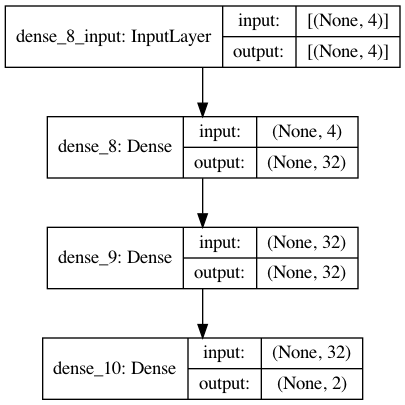

In [272]:
env = gym.make("CartPole-v0")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    # this is not a sigmoid... it's predicting Q(S,A) NOT pr(A) [although it kinda is...]
    keras.layers.Dense(n_outputs)
])

# https://keras.io/api/utils/model_plotting_utils/
tf.keras.utils.plot_model(model, show_shapes=True)

In [279]:
# taken from book

def epsilon_greedy_policy(state, epsilon=0):
    
    '''Take the move that currently looks the best 
       with probability (1-epsilon) or uniformly 
       randomly with probability epsilon
    '''
    
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])
    

In [280]:
# taken from book

def play_one_step(env, state, epsilon):
    
    '''Store Q-Value data: state and action
       and the reward, next state, and done
    '''
    
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [281]:
# taken from book

def sample_experiences(batch_size):
    
    '''Return batch of randomly 
       selected "game instances"
    '''
    
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    
    states, actions, rewards, next_states, dones = \
    [ np.array([experience[field_index] for experience in batch]) for field_index in range(5)]
    
    return states, actions, rewards, next_states, dones


$\underline{\textbf{STARTING AT STATE } s \text{ and following and $\epsilon$-greedy actions }  a}$

$$
\begin{align*}
\displaystyle 
\underbrace{\overset{\huge \text{UPDATE}}{\hat Q(State_s, \text{ACTION}_a)}}_{\text{At STEP } k+1} \longleftarrow & {}
\underbrace{ \sum_{s'} Pr(State_s\rightarrow State_{s'}| \text{ACTION}_a)}_{\epsilon-\text{greedy is mostly picking ACTION}^{optimal} }  \,\times \left[ \underbrace{Reward(State_s\rightarrow State_{s'}| \text{ACTION}_a)}_{{r^{observed}}}
\, + \gamma \cdot \underbrace{\overset{\huge \text{CURRENT}}{\hat Q(State_{s'}, \text{ACTION}^{optimal})}}_{\text{DNN estimate/prediction at STEP } k} \right]
\\\text{i.e.} &\\
\underbrace{\overset{\huge \text{UPDATE}}{\hat Q(State_s, \text{ACTION}^{optimal})}}_{\text{At STEP } k+1} \longleftarrow & {}
\underbrace{ 1}_{(State_s\rightarrow State_{s'}| \text{ACTION}^{optimal})}^{\text{The next state in our playthrough}}  \,\times \left[ 
r^{observed} + \gamma \cdot \underbrace{\overset{\huge \text{CURRENT}}{\hat Q(State_{s'}, \text{ACTION}^{optimal})}}_{\text{DNN estimate/prediction at STEP } k} \right]
\end{align*}
$$


In [282]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    
    '''(1) Show the DNN network a batch of random game instances
       (2) Each instance has state, action, reward, and next_state
       (3) Predict Q(next_state, ALL_ACTIONS) and get the update target (from the optimal of those), i.e.,
           Q(next_state, Action^optmal) = max Q(next_state, ALL_ACTIONS)
    '''
    
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    
    target_Q_values = (rewards + (1-dones)*discount_factor*max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    
    with tf.GradientTape() as tape:
        
        # which actions did we take?
        mask = tf.one_hot(actions, n_outputs)
        model_predicted_Q_values = model(states)
        # use the prediction from the action we took (mask)
        used_actions_model_predicted_Q_values = tf.reduce_sum(model_predicted_Q_values*mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(used_actions_model_predicted_Q_values, target_Q_values))
        
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [283]:
# play a game (600 times)
for episode in range(600):
    
    obs = env.reset()
    # one game max 200 steps; or "done"
    for step in range(200):
        
        # decay epsilon (passed to `epsilon_greedy_policy(...)`)
        epsilon = max(1 - episode/500, 0.01)
        # deque is filled up
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
            
    # make sure we've initialized our "replay buffer"
    if episode > 50:
        training_step(batch_size)

![](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1810.png)

scatch

- Policy (a DNN for an Agent)
    - Stochastic Policy
        - Bayesian Bandit (exploring/exploiting)
    - Policy Space/Search
